<a href="https://colab.research.google.com/github/radanim/TIL/blob/master/CNN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional, Conv1D
import os
import glob

In [ ]:
# 경로 설정
output=glob.glob('/content/drive/MyDrive/dataset/*')
valid =glob.glob('/content/drive/MyDrive/valid/*') 
test=glob.glob('/content/drive/MyDrive/test/*')


# 데이터 프레임 통합하기
df_train = pd.read_csv(output[0])
df_valid = pd.read_csv(valid[0])
df_test = pd.read_csv(test[0])
for i in range (1,20):
    df_temp=pd.read_csv(output[i])
    type(df_temp)
    df_train = pd.concat([df_train, df_temp], ignore_index=True, axis=0)
df_total = pd.concat([df_train, df_valid, df_test], ignore_index=True, axis=0)

# 학습데이터 x,y 분리 
dfx = df_total.drop(columns="FREL(2)")
dfy = df_total["FREL(2)"]
print(dfx.shape, dfy.shape) # (1076, 14), (1076, )

# MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
# 복원을 위해 x, y 따로 스케일링하기
# 스케일링 후 list 형태로 변환하기
mms = MinMaxScaler()
x = mms.fit_transform(dfx).tolist()
y = mms.fit_transform(dfy.to_frame()).tolist() # Series > frame > list, Series 상태에서는 minmaxscaler 적용안됨.

print(len(x), len(y)) # 1076, 1076

window_size = 100
len(y) - window_size

# window_size 만큼만 슬라이싱
# 10step x값으로 다음 step y값을 예측
# 다음 날 종가(i+windows_size)는 포함되지 않도록 X값을 만들고
# 다음 날 종가를 y로 만듦
# window_size = 10 

x_data = []
y_data = []
for i in range(len(y) - window_size):
    # print(i, end=",")
    _x = x[i : i+window_size]
    _y = y[i+window_size]
    x_data.append(_x)
    y_data.append(_y)

a=df_total[df_total.TIME == 0.0].index[19]
print(a)

b=df_total[df_total.TIME == 0.0].index[21]
print(b)

# train, test, valid
X_train = np.array(x_data[:a]) # 80
y_train = np.array(y_data[:a]) #80
X_valid = np.array(x_data[a:b]) # 80
y_valid = np.array(y_data[a:b]) #80
X_test = np.array(x_data[b:]) # 20
y_test = np.array(y_data[b:]) #20
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

# 성능지표 함수
def s_mape(y_true, y_pred):
  ja = tf.math.abs(y_pred - y_true)
  mo = (tf.math.abs(y_true)+tf.math.abs(y_pred))/2
  loss = 100* tf.reduce_mean(ja/mo)
  return loss


# 모델 생성 (validation 데이터 범위 지정해서 돌리기)
data_size = dfx.shape[1]

model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, strides=1, padding='same', activation="relu", input_shape=[None, 14])) #유닛수=히든레이어수
model.add(Dropout(0.3))
model.add(LSTM(units=32, activation='relu', return_sequences=True)) # bi 히든레이어 unit 10+10=20 
model.add(Dropout(0.3))
model.add(LSTM(units=32, activation='relu'))
model.add(Dense(units=1)) # 분류를 하기 위한 학습, output layer = FNN Fully Connected Neural Network
model.summary()

model.compile(optimizer = 'adam',
              loss = 'mse',
              metrics = [s_mape]) # 회귀 (y^ - y)^2 // 분류 categorical entropy


print(X_train.shape, y_train.shape)
#early stopping patience loss값이 연속적으로 patience 횟수만큼 커질때 스탑 
history = model.fit(X_train, y_train, validation_data= (X_valid, y_valid), epochs = 3, batch_size=30, verbose=1, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)]) 
#verbose progress 바가 생기는게 1 아닌게 0 결과만 2 


(23531, 14) (23531,)
23531 23531
20349
22470
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, None, 32)          1376      
                                                                 
 dropout_10 (Dropout)        (None, None, 32)          0         
                                                                 
 lstm_10 (LSTM)              (None, None, 32)          8320      
                                                                 
 dropout_11 (Dropout)        (None, None, 32)          0         
                                                                 
 lstm_11 (LSTM)              (None, 32)                8320      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total par

8/8 [==============================] - 0s 41ms/step - loss: 0.0034 - mape: 75983.8047
[0.0034333858639001846, 75983.8046875]
31/31 [==============================] - 1s 20ms/step


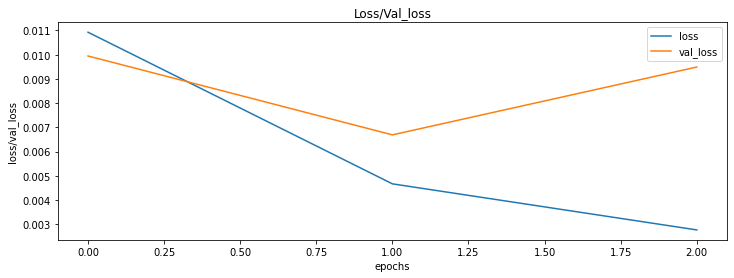

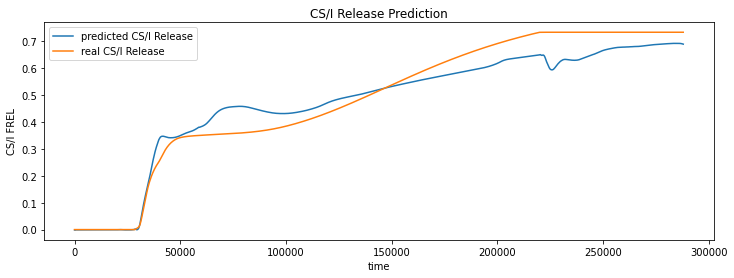

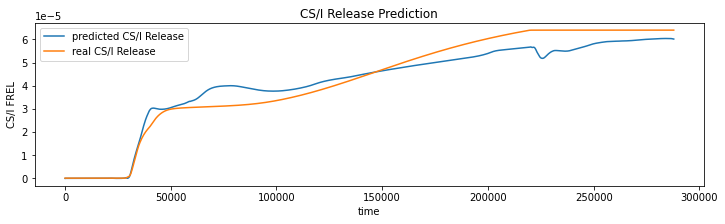

In [11]:
results=model.evaluate(X_test,y_test,batch_size=128)
print(results)

# 모델 설계 및 학습 코드와 시각화 코드 분리 
time_index = df_total[b:-window_size]['TIME']
time_index.shape

# y_pred
# df_hist = pd.DataFrame(history.history)
# df_hist['loss'].plot()
y_pred = model.predict(X_test)

plt.figure(figsize= (12, 4))
plt.title("Loss/Val_loss")
plt.xlabel("epochs")
plt.ylabel("loss/val_loss")
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.savefig('./valid_loss_epoch500_4.png', dpi=500)

# rmse
# np.sqrt(np.square(y_test - y_pred).mean())
# print(y_test.shape, y_pred.shape) # (214, 1), (214, 1)

plt.figure(figsize= (12, 4))
plt.title("CS/I Release Prediction")
plt.xlabel("time")
plt.ylabel("CS/I FREL")
plt.plot(time_index,y_pred.flatten(), label="predicted CS/I Release")
plt.plot(time_index,y_test.flatten(), label="real CS/I Release")
plt.legend()
plt.savefig('./scaling_result_epoch500_4.png', dpi=500)

y_predict_inverse = mms.inverse_transform(y_pred)
y_predict_inverse[:5]

y_test_inverse = mms.inverse_transform(y_test)
y_test_inverse[:5]

# rmse 
# np.sqrt(np.square(y_test_inverse - y_predict_inverse).mean())

# 시각화
plt.figure(figsize = (12, 3))
plt.title("CS/I Release Prediction")
plt.xlabel("time")
plt.ylabel("CS/I FREL")
plt.plot(time_index,y_predict_inverse, label = "predicted CS/I Release")
plt.plot(time_index,y_test_inverse, label="real CS/I Release")
plt.legend()
plt.savefig('./inverse_result_epoch500_4.png', dpi=500)